IMPORTS

In [26]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
from  sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB

READING DATASET AND EXAMINING LABEL


In [4]:
dataset = pd.read_csv("c:/Darknet_all.csv" , low_memory=False) 
df = pd.DataFrame(dataset)
display(df)
print (df['Label'].value_counts(ascending=True))



,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,229,1,1,0,...,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,407,1,1,0,...,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,431,1,1,0,...,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,359,1,1,0,...,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,10778451,591,400,64530,...,20,0,0,0,0,1.440000e+15,3.117718e+06,1.440000e+15,1.440000e+15,AUDIO-STREAMING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141525,10.8.8.246-224.0.0.252-55219-5355-17,10.8.8.246,55219,224.0.0.252,5355,17,411806,2,0,44,...,8,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VOIP
141526,10.8.8.246-224.0.0.252-64207-5355-17,10.8.8.246,64207,224.0.0.252,5355,17,411574,2,0,44,...,8,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VOIP
141527,10.8.8.246-224.0.0.252-61115-5355-17,10.8.8.246,61115,224.0.0.252,5355,17,422299,2,0,44,...,8,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VOIP
141528,10.8.8.246-224.0.0.252-64790-5355-17,10.8.8.246,64790,224.0.0.252,5355,17,411855,2,0,44,...,8,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VOIP


File-transfer         84
Video-streaming      281
AUDIO-STREAMING     1484
VOIP                3566
Email               6145
Video-Streaming     9486
File-Transfer      11098
Chat               11478
Audio-Streaming    16580
Browsing           32808
P2P                48520
Name: Label, dtype: int64


After examining the Label values , we found out some duplicate classes so we dropped them .

In [5]:



dup_values = ['Video-streaming', 'AUDIO-STREAMING','File-transfer' ]
df = df[df.Label.isin(dup_values) == False]    #returing df without duplicated classes
print (df['Label'].value_counts(ascending=True))




VOIP                3566
Email               6145
Video-Streaming     9486
File-Transfer      11098
Chat               11478
Audio-Streaming    16580
Browsing           32808
P2P                48520
Name: Label, dtype: int64


Missing data is data which is not available ( NULL) or infinite values , we will remove the rows which contain any missing data. This shall not affect the model as the dataset is big enough.

In [6]:


df.replace([np.inf, -np.inf], np.nan, inplace=True) #replace infinity values with NaN
df.dropna(inplace=True) #dropping rows with missing values  
print("Dataset size after removal : " ,df.shape)




Dataset size after removal :  (139646, 83)


Dropping unneccassory features like id ,and converting ips to binary then int..

In [7]:
df.drop('Flow ID', axis=1, inplace=True)


i=0
for ip in df['Src IP'].values:
    z = 0
    parts = ip.split('.')
    z = (int(parts[0]) << 24) + (int(parts[1]) << 16) + (int(parts[2]) << 8) + int(parts[3])
    ip= z
    df['Src IP'].values[i]=ip
    i=i+1



i=0    
for ip in df['Dst IP'].values:
    z = 0
    parts = ip.split('.')
    z = (int(parts[0]) << 24) + (int(parts[1]) << 16) + (int(parts[2]) << 8) + int(parts[3])
    ip= z
    df['Dst IP'].values[i]=ip
    i=i+1

Removing 0 variance features..

In [8]:



df_nolabel = df.iloc[:,:-1].values

sel = VarianceThreshold(threshold=0)    
sel.fit_transform(df_nolabel)
arr=sel.get_support()

arr1=np.argwhere(arr == 0)

print("Dataset size before removal " ,df.shape ,"\n")
features_to_remove=[]
for i in arr1 :
    features_to_remove.append((df.columns[i].values[0]))

print("0 variance features : " ,features_to_remove ,"\n")
df.drop(features_to_remove, axis=1, inplace=True)
print("Dataset size after removal " ,df.shape , "\n")

Dataset size before removal  (139646, 82) 

0 variance features :  ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Subflow Bwd Packets', 'Active Mean', 'Active Std', 'Active Max', 'Active Min'] 

Dataset size after removal  (139646, 67) 



Features scaling and splitting the dataset into training and testing subsets.

In [9]:
count=df.shape[1]
x = df.iloc[:,:-1].values
y = df.iloc[:, count-1].values

scaler = StandardScaler().fit(x)
x = scaler.transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)



SMOTE technique to overcome dataset imbalance ..

In [10]:

counter = Counter(y_train) 
print('Before', counter) 
smtom = SMOTEENN () 
X_train_smtom, y_train_smtom = smtom.fit_resample (X_train, y_train)
counter = Counter(y_train_smtom) 
print('After', counter)


Before Counter({'P2P': 33991, 'Browsing': 22996, 'Audio-Streaming': 11601, 'Chat': 7996, 'File-Transfer': 7752, 'Video-Streaming': 6629, 'Email': 4330, 'VOIP': 2457})
After Counter({'P2P': 33101, 'Audio-Streaming': 30214, 'File-Transfer': 29964, 'Browsing': 29059, 'VOIP': 28629, 'Video-Streaming': 28138, 'Email': 28105, 'Chat': 26813})


In [11]:
clf = DecisionTreeClassifier()


from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
    
}

grid_search = GridSearchCV(estimator=clf, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

grid_search.fit(X_train_smtom, y_train_smtom)

grid_search.best_estimator_


Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.5min finished


DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5)

In [12]:
best_DT=DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5)


best_DT = best_DT.fit(X_train_smtom, y_train_smtom)


y_pred = best_DT.predict(X_test)
print(classification_report(y_test, y_pred))

y_train_pred = best_DT.predict(X_train_smtom)
print(classification_report(y_train_smtom, y_train_pred))



                 precision    recall  f1-score   support

Audio-Streaming       0.93      0.86      0.90      4979
       Browsing       0.96      0.91      0.94      9812
           Chat       0.82      0.68      0.74      3477
          Email       0.62      0.73      0.67      1813
  File-Transfer       0.78      0.83      0.81      3337
            P2P       1.00      0.99      0.99     14529
           VOIP       0.61      0.76      0.68      1109
Video-Streaming       0.64      0.80      0.72      2838

       accuracy                           0.89     41894
      macro avg       0.80      0.82      0.81     41894
   weighted avg       0.90      0.89      0.89     41894

                 precision    recall  f1-score   support

Audio-Streaming       0.99      0.96      0.97     30214
       Browsing       0.98      0.98      0.98     29059
           Chat       0.94      0.89      0.91     26813
          Email       0.89      0.93      0.91     28105
  File-Transfer       0.97 

In [13]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train_smtom, y_train_smtom)

#Predict the response for test dataset
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

Audio-Streaming       0.91      0.85      0.88      4979
       Browsing       0.93      0.86      0.89      9812
           Chat       0.81      0.69      0.74      3477
          Email       0.60      0.71      0.65      1813
  File-Transfer       0.69      0.78      0.73      3337
            P2P       0.99      0.97      0.98     14529
           VOIP       0.58      0.70      0.63      1109
Video-Streaming       0.57      0.73      0.64      2838

       accuracy                           0.86     41894
      macro avg       0.76      0.79      0.77     41894
   weighted avg       0.87      0.86      0.86     41894



                 precision    recall  f1-score   support

Audio-Streaming       0.94      0.87      0.90      4968
       Browsing       0.95      0.93      0.94      9878
           Chat       0.86      0.65      0.74      3401
          Email       0.59      0.70      0.64      1779
  File-Transfer       0.84      0.83      0.84      3346
            P2P       1.00      1.00      1.00     14684
           VOIP       0.57      0.84      0.68      1039
Video-Streaming       0.67      0.82      0.74      2799

       accuracy                           0.90     41894
      macro avg       0.80      0.83      0.81     41894
   weighted avg       0.91      0.90      0.90     41894



[Text(845.3346588474924, 537.4227272727273, 'X[23] <= -0.14\ngini = 0.875\nsamples = 146823\nvalue = [30379, 28919, 26832, 27572, 29708, 32701, 28458, 28041]'),
 Text(617.2803523270329, 525.0681818181819, 'X[18] <= 0.047\ngini = 0.848\nsamples = 94436\nvalue = [29196, 27205, 5214, 10872, 22147, 23739, 7938, 23255]'),
 Text(532.9109440382023, 512.7136363636364, 'X[65] <= 1.208\ngini = 0.842\nsamples = 72550\nvalue = [8461, 26458, 4751, 10128, 16810, 23552, 7408, 17244]'),
 Text(435.33397302301955, 500.3590909090909, 'X[61] <= 0.609\ngini = 0.858\nsamples = 55932\nvalue = [8101, 12938, 4751, 10128, 16572, 11399, 7408, 17244]'),
 Text(334.5438417152943, 488.00454545454545, 'X[5] <= 2.637\ngini = 0.855\nsamples = 45092\nvalue = [4020, 12936, 3672, 8859, 14078, 11399, 7088, 9280]'),
 Text(225.22573341298914, 475.65000000000003, 'X[44] <= 0.972\ngini = 0.847\nsamples = 42795\nvalue = [3635, 12933, 3570, 8810, 14038, 11390, 4116, 9228]'),
 Text(100.12578040211046, 463.29545454545456, 'X[62] <

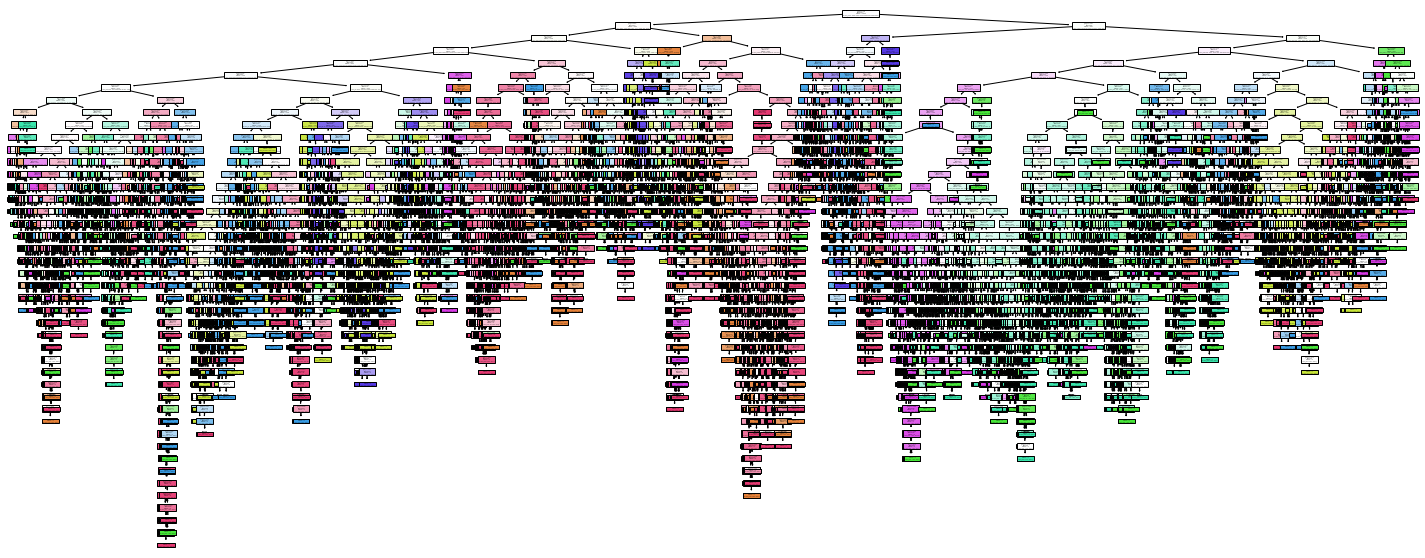

In [37]:
clf=RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train_smtom, y_train_smtom)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25, 10))
plot_tree(clf.estimators_[0], 
          filled=True,)

In [17]:
# Logistic Regression
clf = LogisticRegression()
log=clf.fit(X_train_smtom,y_train_smtom)
y_pred =log.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\lenevo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 precision    recall  f1-score   support

Audio-Streaming       0.82      0.66      0.73      4979
       Browsing       0.77      0.77      0.77      9812
           Chat       0.60      0.37      0.46      3477
          Email       0.24      0.23      0.24      1813
  File-Transfer       0.40      0.45      0.42      3337
            P2P       0.93      0.87      0.90     14529
           VOIP       0.26      0.78      0.39      1109
Video-Streaming       0.41      0.52      0.46      2838

       accuracy                           0.69     41894
      macro avg       0.55      0.58      0.55     41894
   weighted avg       0.73      0.69      0.70     41894



In [21]:
# Single Perceprton
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X_train_smtom, y_train_smtom)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

Audio-Streaming       0.61      0.72      0.66      4979
       Browsing       0.87      0.46      0.60      9812
           Chat       0.22      0.09      0.13      3477
          Email       0.28      0.63      0.39      1813
  File-Transfer       0.18      0.45      0.26      3337
            P2P       0.93      0.77      0.84     14529
           VOIP       0.19      0.13      0.16      1109
Video-Streaming       0.28      0.43      0.34      2838

       accuracy                           0.56     41894
      macro avg       0.44      0.46      0.42     41894
   weighted avg       0.67      0.56      0.59     41894



Iteration 1, loss = 0.91684479
Iteration 2, loss = 0.66486576
Iteration 3, loss = 0.60313435
Iteration 4, loss = 0.56848992
Iteration 5, loss = 0.54462822
Iteration 6, loss = 0.52656361
Iteration 7, loss = 0.51333547
Iteration 8, loss = 0.50208050
Iteration 9, loss = 0.49350915
Iteration 10, loss = 0.48543083
Iteration 11, loss = 0.47864772
Iteration 12, loss = 0.47254333
Iteration 13, loss = 0.46696147
Iteration 14, loss = 0.46170959
Iteration 15, loss = 0.45750179
Iteration 16, loss = 0.45278684
Iteration 17, loss = 0.44967270
Iteration 18, loss = 0.44514593
Iteration 19, loss = 0.44230542
Iteration 20, loss = 0.43979431
Iteration 21, loss = 0.43673259
Iteration 22, loss = 0.43364447
Iteration 23, loss = 0.43058856
Iteration 24, loss = 0.43032015
Iteration 25, loss = 0.42705244
Iteration 26, loss = 0.42535835
Iteration 27, loss = 0.42297396
Iteration 28, loss = 0.42048058
Iteration 29, loss = 0.41896489
Iteration 30, loss = 0.41812597
Iteration 31, loss = 0.41550835
Iteration 32, los

C:\Users\lenevo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(


                 precision    recall  f1-score   support

Audio-Streaming       0.94      0.76      0.84      4979
       Browsing       0.91      0.90      0.90      9812
           Chat       0.80      0.48      0.60      3477
          Email       0.53      0.37      0.44      1813
  File-Transfer       0.74      0.69      0.71      3337
            P2P       0.99      0.98      0.99     14529
           VOIP       0.30      0.90      0.46      1109
Video-Streaming       0.53      0.76      0.62      2838

       accuracy                           0.83     41894
      macro avg       0.72      0.73      0.69     41894
   weighted avg       0.86      0.83      0.83     41894

{'Video-Streaming', 'Audio-Streaming', 'Email', 'VOIP', 'P2P', 'File-Transfer', 'Chat', 'Browsing'}
{'Video-Streaming', 'Audio-Streaming', 'VOIP', 'Email', 'P2P', 'File-Transfer', 'Chat', 'Browsing'}


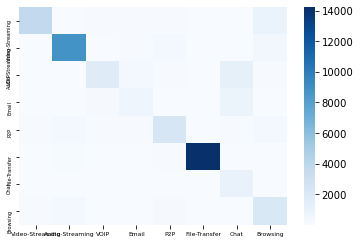

In [23]:
classifier = MLPClassifier(hidden_layer_sizes=100,max_iter=35,activation='relu',solver='adam',verbose=(10),random_state=762,learning_rate='invscaling')
classifier.fit(X_train_smtom,y_train_smtom)

preds = classifier.predict(X_test)

score = classification_report(y_test, preds)
print(str(score))
print(set(df.Label))
print(set(preds))
cfx=confusion_matrix(y_test, preds)
cfxH = sn.heatmap(cfx, annot=False, cmap='Blues')
cfxH.xaxis.set_ticklabels(list(set(preds)))
cfxH.yaxis.set_ticklabels(list(set(preds)))
plt.xticks(fontsize=6)
plt.yticks(fontsize=5)

plt.show()

In [27]:
gnb = GaussianNB()
gnb.fit(X_train_smtom, y_train_smtom)
 
# making predictions on the testing set
y_pred = gnb.predict(X_test)

# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print(classification_report(y_test,y_pred))

                 precision    recall  f1-score   support

Audio-Streaming       0.36      0.01      0.01      4979
       Browsing       0.35      0.52      0.42      9812
           Chat       0.14      0.86      0.24      3477
          Email       0.23      0.09      0.13      1813
  File-Transfer       0.52      0.11      0.18      3337
            P2P       0.61      0.15      0.24     14529
           VOIP       0.29      0.06      0.09      1109
Video-Streaming       0.17      0.05      0.08      2838

       accuracy                           0.26     41894
      macro avg       0.33      0.23      0.17     41894
   weighted avg       0.42      0.26      0.23     41894



In [ ]:
# SVM
clf = svm.SVC(kernel='linear')
clf.fit(X_train_smtom, y_train_smtom)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))